<a href="https://colab.research.google.com/github/MalakSwar/AI_Project/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Importing the dataset

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report


df = pd.read_csv('https://raw.githubusercontent.com/MalakSwar/AI_Project/refs/heads/main/Churn_Dataset.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#2) Data Analysis

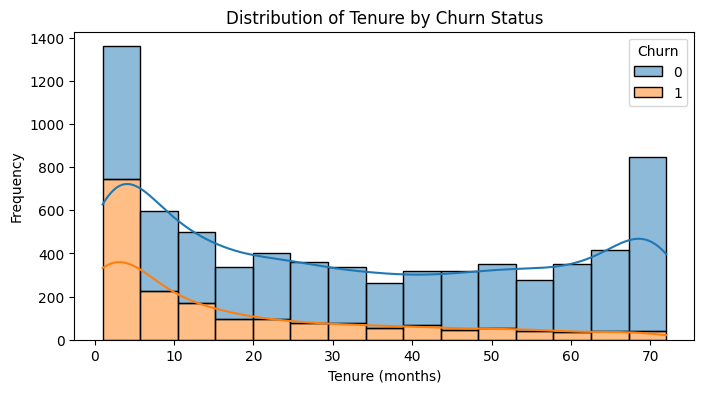

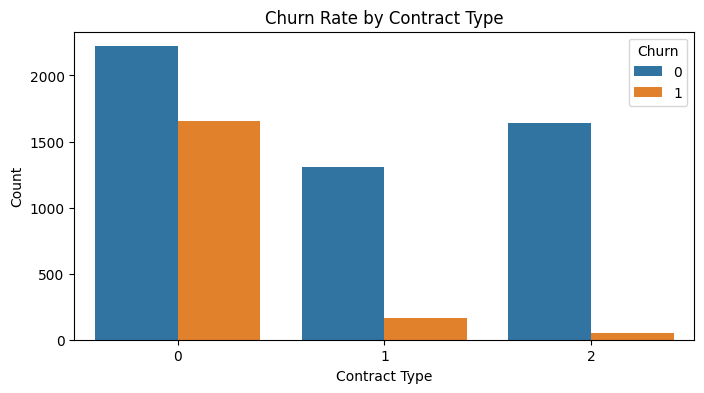

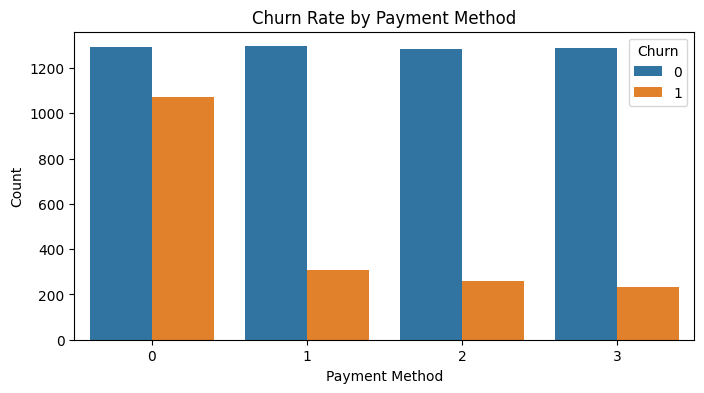

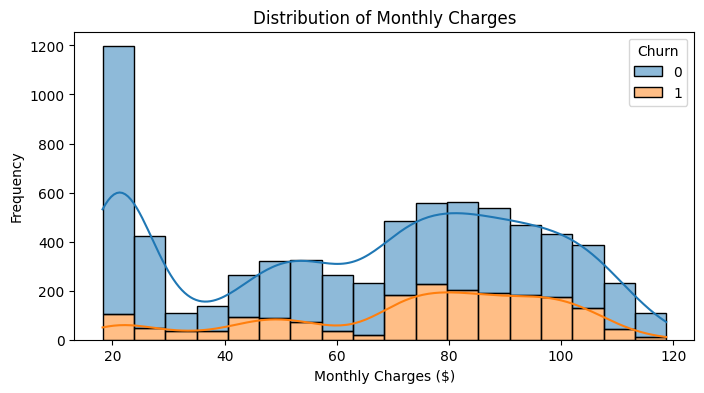

Correlation with Churn:
 tenure           -0.354049
MonthlyCharges    0.192858
Churn             1.000000
Name: Churn, dtype: float64


In [15]:
df = df[(df['TotalCharges'] != ' ') & (df['TotalCharges'] != '')]
df.loc[:, 'TotalCharges'] = df['TotalCharges'].astype(float)
df.loc[:, 'Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
contract_mapping = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
df.loc[:, 'Contract'] = df['Contract'].map(contract_mapping)
payment_mapping = {'Electronic check': 0, 'Mailed check': 1, 'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}
df.loc[:,'PaymentMethod'] = df['PaymentMethod'].map(payment_mapping)






plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, multiple="stack")
plt.title("Distribution of Tenure by Churn Status")
plt.xlabel("Tenure (months)")
plt.ylabel("Frequency")
plt.show()


plt.figure(figsize=(8, 4))
sns.countplot(x='Contract', data=df, hue='Churn')
plt.title("Churn Rate by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(8, 4))
sns.countplot(x='PaymentMethod', data=df, hue='Churn')
plt.title("Churn Rate by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True, multiple="stack")
plt.title("Distribution of Monthly Charges")
plt.xlabel("Monthly Charges ($)")
plt.ylabel("Frequency")
plt.show()

correlations = df[['tenure', 'MonthlyCharges', 'Churn']].corr()
print("Correlation with Churn:\n", correlations['Churn'])




#Catigorising Tenure Column

In [16]:
def tenure_state(tenure):
    if tenure <= 12:
        return 'low'
    elif 12 < tenure <= 36:
        return 'medium'
    else:
        return 'high'

df['Tenure'] = df['tenure'].apply(tenure_state)

#Applying Markov Model

In [16]:
markov_model = {}

for i in range(len(df['Tenure'])):
    curr_state = df['Tenure'].iloc[i]
    next_state = df['Churn'].iloc[i]

    if curr_state not in markov_model:
        markov_model[curr_state] = {next_state: 1}
    else:
        markov_model[curr_state][next_state] = markov_model[curr_state].get(next_state, 0) + 1

for curr_state, transition in markov_model.items():
    total = sum(transition.values())
    for state in transition:
        markov_model[curr_state][state] /= total

print("Number of states =", len(markov_model.keys()))
print("Transitions from 'Low':", markov_model.get('low'))
print("Transitions from 'Medium':", markov_model.get('medium'))
print("Transitions from 'High':", markov_model.get('high'))


In [17]:

hidden_states = list(zip(df['Contract'], df['PaymentMethod']))
hidden_states = np.array(hidden_states)

observed_states = df['Churn'].values
observed_states = observed_states.reshape(-1, 1)  #

model = hmm.MultinomialHMM(n_components=2, n_iter=100, random_state=42)

model.fit(observed_states)

predicted_churn = model.predict(observed_states)


print("Predicted churn sequence:", predicted_churn)


NameError: name 'hmm' is not defined